# scRNA-seq Analysis Pipeline

This tutorial contains a basic pipeline for analysis of scRNA-seq data. We primarily use the Scanpy package in Python, and some independently curated functions for data processing and visualization.

The steps in this tutorial are based on the practices discussed in [Leucken and Theis (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6582955/). Additoinally, I draw on material from the [Seurat](http://bioconductor.org/books/3.13/OSCA.basic/index.html) and [Scanpy](https://scanpy.readthedocs.io/en/stable/tutorials.html) websites, which are great resources to learn more about scRNA-seq methods and analysis.

<img src="forelimb.png">

We will replicate the scRNA-seq analysis on the E10.5-E15 day mouse forelimb 10X scRNA-seq dataset published by [He et al.](https://www.nature.com/articles/s41586-020-2536-x) in their paper __"The changing mouse embryo transcriptome at whole tissue and single-cell resolution."__ The dataset sequences one pair of forelimbs at stages E10.5, E11.5, E12.5, E13.5, and E15 with the 10X library prep for scRNA-seq. 

## Table of contents
* ### [scRNA-seq data format](#1-bullet)
    * #### [AnnData objects](#1a-bullet)
* ### [Data quality control](#2-bullet)
    * #### [Mitochondrial gene quality control](#2a-bullet)
    * #### [Filtering the data](#2b-bullet)
* ### [Data normalization](#3-bullet)
* ### [Highly-variable gene selection](#4-bullet)
    * #### [Adding pathway genes of interest](#4a-bullet)
    * #### [Regressing out covariates and scaling data](#4b-bullet)
* ### [Data visualization and clustering](#5-bullet)
    * #### [Principal component analysis (PCA)](#5a-bullet)
    * #### [Neighborhood graph](#5b-bullet)
    * #### [Clustering](#5c-bullet)
    * #### [Visualization](#5d-bullet)

In [1]:
# Import basic packages
import numpy as np
import pandas as pd
import seaborn as sb

# Import Scanpy
import scanpy as sc

# Import a module I wrote for the analysis
import module as sc_sp

# Set Scanpy's verbose output
sc.settings.verbosity = 3   # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)

<div class="alert alert-info">

**Note**

Set the correct directories to store data and results below.

</div>

In [2]:
# Set directories for the data, results, and figures. SPECIFY AS APPROPRIATE
datadir = './wold_forelimb_10X/data/'
resdir = './wold_forelimb_10X/results/'

### scRNA-seq Data Format <a class="anchor" id="1-bullet"></a>

Raw scRNA-seq data consists of RNA counts for the whole transcriptome of each cell. We typically store these counts as a matrix, with rows representing observations, or cells, and columns representing variables, or genes.

He et al. upload their count matrix as a tsv file, available at https://cells.ucsc.edu/?bp=limb&ds=mouse-limb. (Note: Their gene expression data is FPKM normalized to account for differences in sequencing depth due to gene length.)

#### AnnData Objects <a class="anchor" id="1a-bullet"></a>

We can read this tsv file to create an AnnData object, a [class](https://anndata.readthedocs.io/en/latest/index.html) that Scanpy uses to store scRNA-seq data along with annotations, such as metadata or alternative data representations.
- Counts are stored in the matrix `X`
- Cell-level information is stored in the dataframe `obs` to which annotations can be added (i.e. `adata.obs["anno"]`
- Gene information is stored in the dataframe `var`
- Unstructured data (i.e. a matrix of a lower-dimensional visualization) is stored in the `uns` dictionary

<img src="anndata_schema.svg" width="600" height="500" align="middle">

In [3]:
%%time
# We create the AnnData object by uploading the gene expression matrix.
file = datadir + "exprMatrix.tsv"

adata = sc.read_csv(file, delimiter = "\t").T

adata

CPU times: user 6min 5s, sys: 33.9 s, total: 6min 39s
Wall time: 6min 46s


AnnData object with n_obs × n_vars = 90637 × 43346

He et al. also upload a tsv file with cell-level metadata, available at https://cells.ucsc.edu/?bp=limb&ds=mouse-limb.

In [4]:
# Import the metadata
metadata_file = datadir + "meta.tsv"
meta_df = pd.read_csv(metadata_file, delimiter = "\t")
meta_df = meta_df.set_index(meta_df['index'])

meta_df.head()

,index,cell_type,batch,doublet_scores,nCount_RNA,nFeatures_RNA,Percent Mitochond.,stage,UMI Count,doublet_corrected_p,doublet_corrected_p_less_than_0_1
index,,,,,,,,,,,
limb12_13_0AAACCTGAGATCGATA_1,limb12_13_0AAACCTGAGATCGATA_1,Chondrocyte,7,0.216129,11426.0,3404,0.016366,13.0,11428.0,0.000002,1
limb12_13_0AAACCTGAGATGAGAG_1,limb12_13_0AAACCTGAGATGAGAG_1,Mesenchymal 2,7,0.223881,6474.0,2322,0.013284,13.0,6474.0,0.815298,0
limb12_13_0AAACCTGAGCAGATCG_1,limb12_13_0AAACCTGAGCAGATCG_1,Epithelial 1,7,0.014121,8269.0,2162,0.011610,13.0,8273.0,0.896632,0
limb12_13_0AAACCTGAGCGATCCC_1,limb12_13_0AAACCTGAGCGATCCC_1,Fibroblast,7,0.065789,14966.0,3771,0.011092,13.0,14972.0,0.815298,0
limb12_13_0AAACCTGAGTGTACCT_1,limb12_13_0AAACCTGAGTGTACCT_1,Perichondrial,7,0.125270,7649.0,2517,0.018042,13.0,7651.0,0.815298,0


We can add this metadata as cell-level information accessible with a call to `adata.obs`.

In [5]:
# Set observation annotations
adata.obs['batch'] = [str(i) for i in meta_df['batch']] # store batches as strings, not as numerical quantities
adata.obs['stage'] = meta_df['stage']                   # store stages as numerical quantities
adata.obs['cell_type'] = meta_df['cell_type']

In [6]:
adata

AnnData object with n_obs × n_vars = 90637 × 43346
    obs: 'batch', 'stage', 'cell_type'

### Data quality control <a class="anchor" id="2-bullet"></a>

Quality control is an important step in scRNA-seq analysis to filter out low-quality cells. These can arise from different steps in the experimental procedure, such as cell damage during tissue dissociation or insufficient amplification during the library prep. 

Useful parameters for evaluating cell quality include
- Library size: the total raw counts for each cell. A small library size means that RNA was lost during isolation or library prep, and thus these cells' counts are not reflective of true values in the population.
- Number of genes expressed: cells with few genes expressed suggest that RNA capture was poor as well.
- Spike-in reads: since each cell receive the same quantity of spike-ins, the relative abundance of spike-in counts to the total counts in a cell quantifies amplification bias. Moreover, cells with high spike-in counts indicate loss of RNA.
- Mitochondrial gene expression: if spike-in counts are not available, mitochondrial gene counts can serve as an indicator of poor quality cells. Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [7]:
%%time

sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)

# This is the gene express matrix from AnnData as a numpy matrix
X = np.matrix(adata.X)

# Set annotations to the AnnData object for total counts and # of genes per cell
adata.obs['n_total_counts_per_cell'] = (X.sum(axis=1).A1) # We can sum along the columns to get total counts per cell
adata.obs['n_genes_per_cell'] = X.astype(bool).astype(int).sum(axis=1).A1 # Sum along columns to get genes/cell
# A1 operation "flattens" the matrix into a numpy array

CPU times: user 7min 44s, sys: 3min 19s, total: 11min 4s
Wall time: 12min 32s


To make our analyses more computationally feasible as well as reduce noise for downstream steps, we can further reduce the dimensionality of our dataset by excluding genes that are not informative of cellular heterogeneity, especially lowly-expressed genes. We can identify such genes by quantifying the number of cells that a gene is expressed in.

In [8]:
# Quantify the number of cells per gene
adata.var['n_cells_per_gene'] = X.astype(bool).astype(int).sum(axis=0).A1 

Let's summarize these statistics.

normalizing counts per cell
    finished (0:00:47)


/Users/niveditakanrar/opt/anaconda3/envs/test/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical
/Users/niveditakanrar/opt/anaconda3/envs/test/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


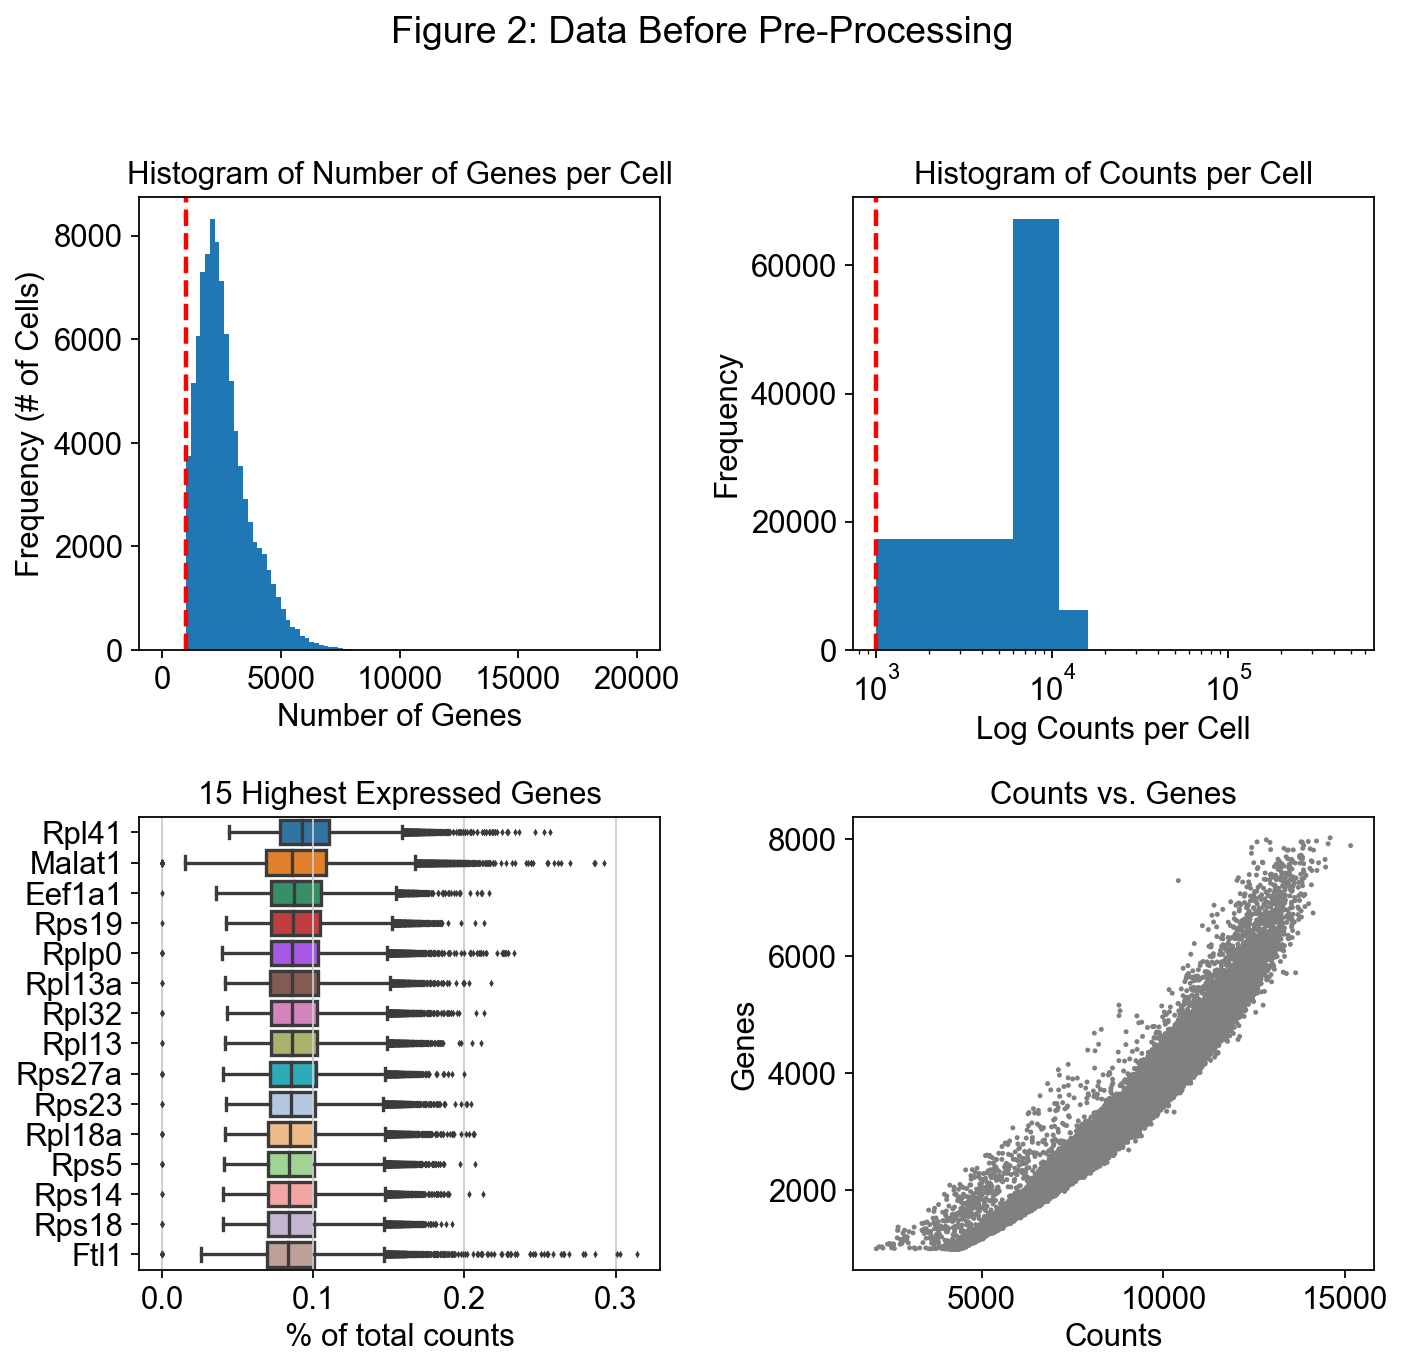

In [9]:
# Visualizations of QC stats
pre_processed = sc_sp.vis_pre_processing(
    adata,
    genes_range=(0, 20000),
    counts_range=(1e3, 5e5),
    title='Figure 2: Data Before Pre-Processing',
    genes_threshold=1000,
    counts_threshold=1000
)

We can see that the data generally passes our thresholds (red dotted lines) and is generally high-quality. 
Additionally, ribosomal genes (Rpl and Rps) are some of the most highly expressed genes in our cells.

In [10]:
avg_genes = np.average(adata.obs['n_genes_per_cell'])
avg_cells = np.average(adata.obs['n_total_counts_per_cell'])
avg = "The average number of genes/cell is {:.0f} and the average number of counts/cell is {:.0f}.".format(avg_genes, avg_cells)

print(avg)

The average number of genes/cell is 2609 and the average number of counts/cell is 7734.


#### Mitochondrial gene quality control <a class="anchor" id="2a-bullet"></a>

Since this dataset does not have UMI counts included, we will instead use mitochondrial gene expression as another quality control. 

The Scanpy package has its own function `sc.pp.calculate_qc_metrics` to calculate different quality statistics on a set of genes.

In [11]:
# Add an annotation to the list of genes that indicates whether a gene is mitochondrial or not

adata.var['mt'] = adata.var_names.str.startswith('mt-') # mitochondrial genes in this dataset starts with mt-

# Compute quality control statistics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

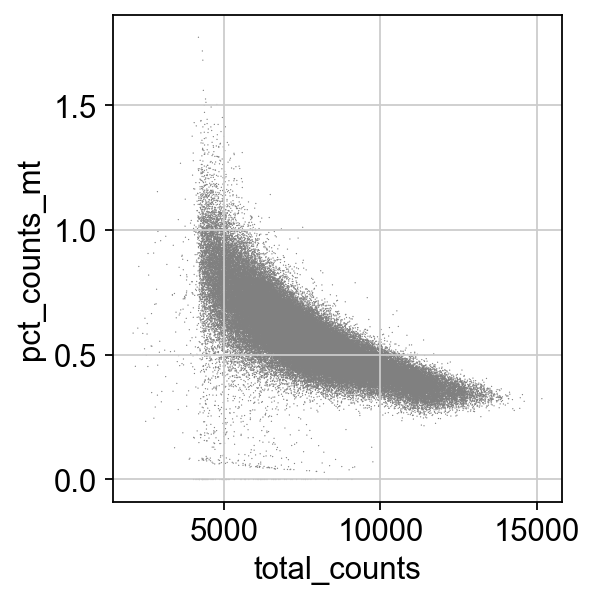

In [12]:
# Plot the percentage of mitochondrial genes
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

#### Filtering the data <a class="anchor" id="2b-bullet"></a>

Based on the QC data above, we can apply a filter on genes/cell and counts/cell. A typical value for both thresholds is 2,000, which we will apply below.

He et al. also apply a filter on lowly-expressing genes, and we will apply the same filter of only keeping genes expressed in 0.1% of cells (~90 cells).

In [13]:
%%time

adata = sc_sp.filter_data(
    adata,
    min_counts=0, 
    min_genes=1000, 
    min_cells=int(adata.shape[0]*0.001)
)

filtered out 25791 genes that are detected in less than 90 cells
CPU times: user 2min 21s, sys: 2min 23s, total: 4min 44s
Wall time: 5min 46s


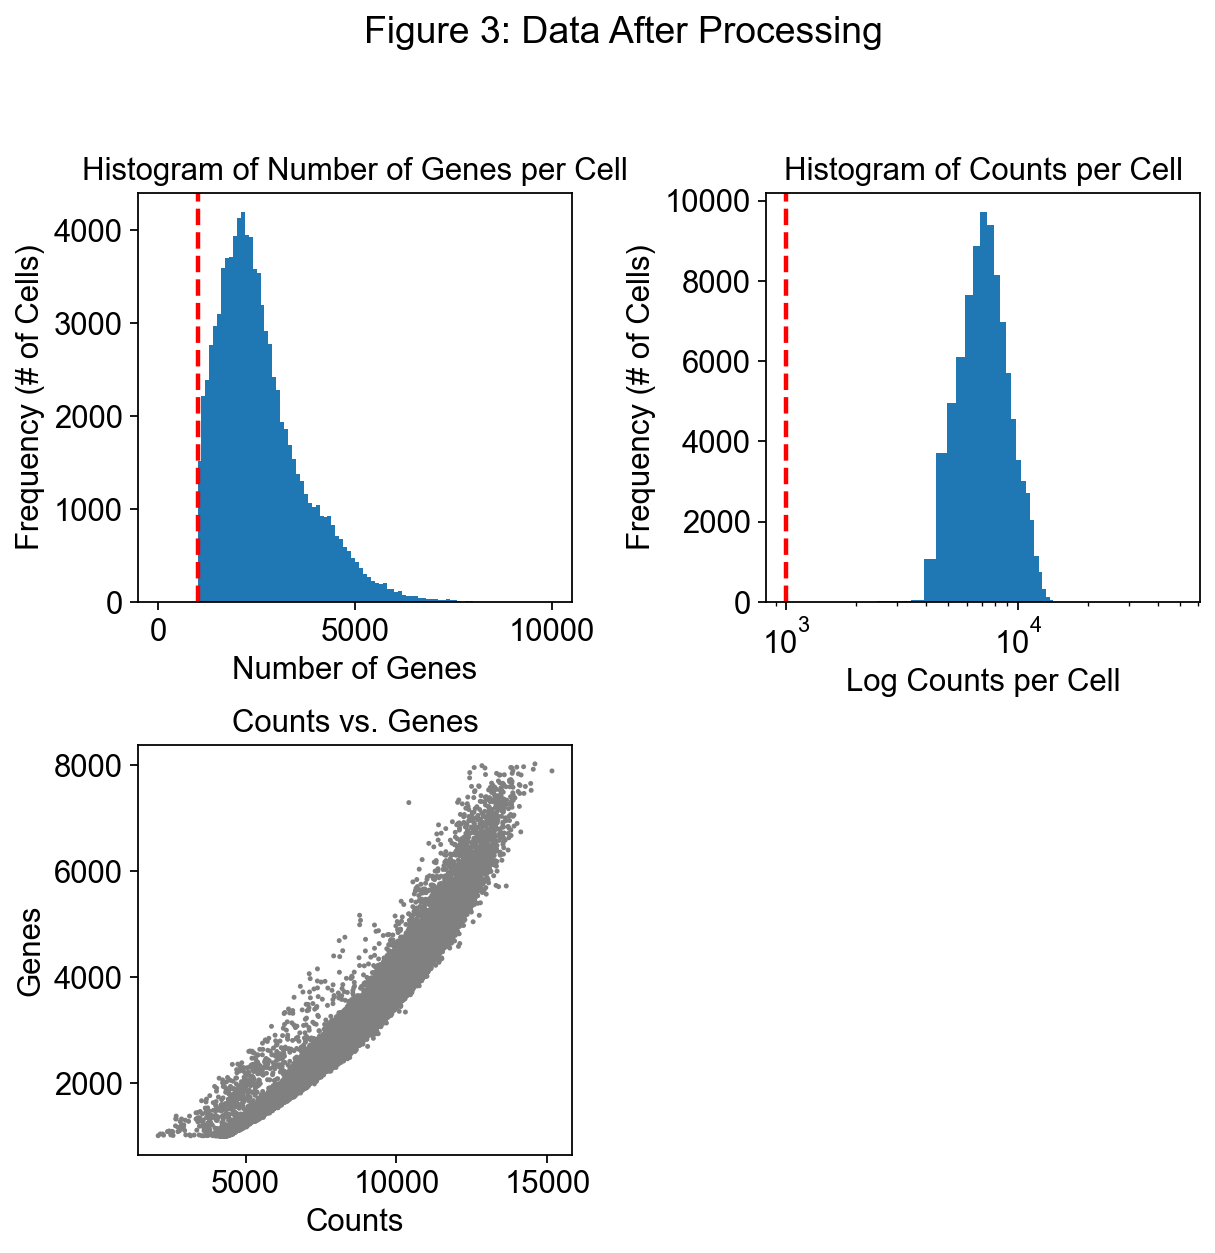

In [14]:
post_processing = sc_sp.vis_post_processing(
    adata, 
    genes_range=(0, 10000),
    counts_range=(1e3, 5e4),
    title='Figure 3: Data After Processing',
    genes_threshold = 1000, 
    counts_threshold=1000
)

### Data Normalization <a class="anchor" id="3-bullet"></a>

Differences in sequencing depth often arise due to technical differences across cells during library prep, or differences in the amount of starting material captured during RNA isolation. Normalization aims to removes these effects so that there is no bias during comparison of expression profiles between cells.

Scanpy uses a simple method, scaling normalization (`sc.pp.normalize_total`), to correct for differences in sequencing depth between cells. Essentially, all cells' counts are scaled so that each cell has the same number of total counts, here set to be $10^4$.

In [15]:
# We save a copy of the AnnData object prior to normalization for differential expression testing.
pre_norm = adata.copy()

sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:01)


Count data is also extremely right-skewed, and many downstream analysis steps assume a normal distribution of counts. To bring the count data closer to normality, we perform a `log(x + 1)` transformation.

In [16]:
sc.pp.log1p(adata)

In [17]:
adata

AnnData object with n_obs × n_vars = 90637 × 17555
    obs: 'batch', 'stage', 'cell_type', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'n_cells', 'n_cells_per_gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

### Highly-Variable Gene Selection <a class="anchor" id="4-bullet"></a>

Even after filtering low-expression genes, we have about 8,000 genes in our dataset. To further reduce the dimensionality of our data, we can select genes only informative of the heterogeneity of our data. Scanpy selects a specified number of these highly variable genes (HVGS) by binning genes by their mean expression, and selecting the top genes from each bin that have the highest dispersion.

In [18]:
%%time

sc.pp.highly_variable_genes(
    adata,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    n_top_genes=4000
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:34)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
CPU times: user 15.7 s, sys: 15.9 s, total: 31.6 s
Wall time: 34.3 s


#### Adding pathway genes of interest <a class="anchor" id="4a-bullet"></a>

We may be interested in genes that are not necessarily HVGs, but that do indeed pass our quality-controls above. We can "force" our gene expression matrix to keep these genes for downstream analysis.

The Notch genes are important in developmental processes, and we can include these in our dataset if they are not already HVGs.

In [19]:
# List of all Notch genes

notch = ["Dll1", "Dll3","Dll4", "Jag1", "Jag2", "Notch1", "Notch2", 
         "Notch3", "Notch4", "Mfng", "Rfng", "Lfng"]

# Only keep the Notch genes that pass our QC filters
notch = sc_sp.get_genes(adata, notch)

# Get the genes we're interested in saving--the HVGs and the Notch genes
genes = list(set(list(adata.var.index[adata.var.highly_variable]) + notch))

adata = adata[:,genes]

In [20]:
adata

View of AnnData object with n_obs × n_vars = 90637 × 4010
    obs: 'batch', 'stage', 'cell_type', 'n_genes', 'n_total_counts_per_cell', 'n_genes_per_cell', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'n_cells', 'n_cells_per_gene', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

#### Regressing out covariates and scaling data <a class="anchor" id="4b-bullet"></a>

Our normalized, `log(x + 1)` transformed counts are useful for later steps in our analysis, especially comparison of gene expression. Prior to further transforming our counts, we can save these normalized data in the `raw` attribute of our AnnData object for later use.

In [21]:
# We can save the normalized counts in the raw attribute of the AnnData object
adata.raw = adata

Normalization accounts for differences in count depth between cells, but there may be additional biological covariates whose effect we may want to correct for. Scanpy implements these corrections through simple linear regression at the gene-level based on scores of the selected factors. A factor that is commonly regressed out is cell-cycle effects, since cell-cycle stage could strongly impact expression values. However, in developmental datasets, such regression could mask important differentiation processes, so we will not regress this factor out here. 

We will regress out variation in mitochondrial gene expression (as quantified by the `pct_counts_mt` annotation), which is indicative of cell stress levels. Additionally, we will regress out differences in total counts, to correct gene counts for differences in RNA capture amounts per cell.

In [22]:
sc.pp.regress_out(adata, ['pct_counts_mt'])
sc.pp.regress_out(adata, ['n_total_counts_per_cell'])

regressing out ['pct_counts_mt']
    finished (0:03:30)
regressing out ['n_total_counts_per_cell']
    finished (0:02:07)


In the same way we normalize counts for fair comparison between cells, we may want to normalize our individual genes' counts to account for differences in magnitude of gene expression, RNA capture rates etc. if we want to perform differential expression testing. We can do so by scaling each gene's counts to have zero mean and unit variance. This scaling essentially weights each gene equally, which may not necessarily be true biologically. For this reason, when we seek to quantify gene expression (downstream), we typically use normalized counts prior to this scaling step.

In [23]:
sc.pp.scale(adata)

## Data Visualization and Clustering <a class="anchor" id="5-bullet"></a>

### Principal component analysis (PCA) <a class="anchor" id="5a-bullet"></a>

PCA analysis reduces the dimensionality of data by identifying the main axes of variation and thus reducing noise in the data.

In [24]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)


A variance plot displays the contribution of individual PCs to the total variance of the data. This tells us about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.leiden()` or UMAP `sc.tl.umap()`. A rough estimate of the PCs from the "bend" in the plot is sufficient for downstream steps.

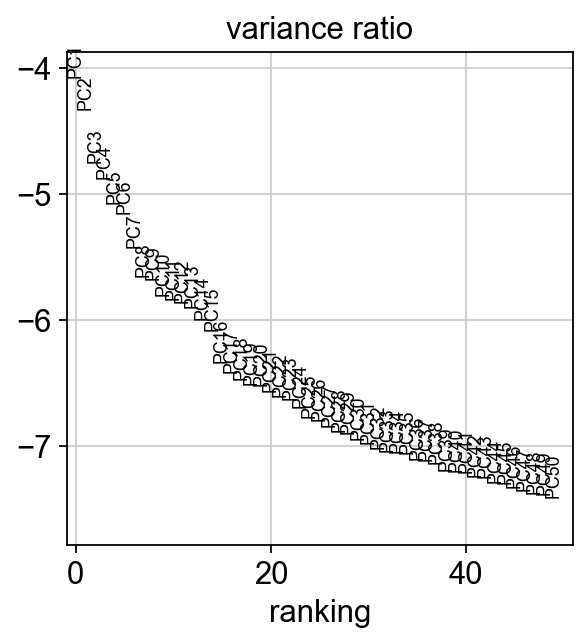

In [25]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

### Computing the Neighborhood Graph and UMAPs <a class="anchor" id="5b-bullet"></a>

We can compute a neighborhood graph of cells using a PCA representation of our data matrix. The resulting neighborhood graph can be used for further clustering and further dimensionality reduction.

Here, we can specify the number of PCs (`n_pcs`) used for constructing the neighbor map, and additionally the number of neighbors for each member (`n_neighbors`). Note, a larger number of neighbors (i.e. >15) is useful for capturing global relationships (e.g. in a large dataset like this forelimb atlas, where we may be interested in capturing broader cell type relationships), whereas smaller neighbor values capture more local connectivities.

In [26]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=25)

computing neighbors
    using 'X_pca' with n_pcs = 25


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


Typical scRNA-seq analysis pipelines also include projection of data to 2-3 dimensions using methods like UMAP. However, these lower-dimensional representations have been shown to distort data [Chari, Banerjee, and Pachter, 2021)](https://www.biorxiv.org/content/10.1101/2021.08.25.457696v1), and thus should not be relied upon for making conclusions on the data.

In [27]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:02)


### Clustering <a class="anchor" id="5c-bullet"></a>

We can identify groups of similar cells by applying clustering algorithms. The most robust algorithm available currently is the Leiden algorithm, which we use below. This algorithm directly clusters on the neighborhood graph of cells that we have already computed. 

In [28]:
sc.tl.leiden(adata, resolution = 1.0) 
# resolution specifies the coarse-ness of clustering, a smaller value means fewer, and larger clusters

running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:42)


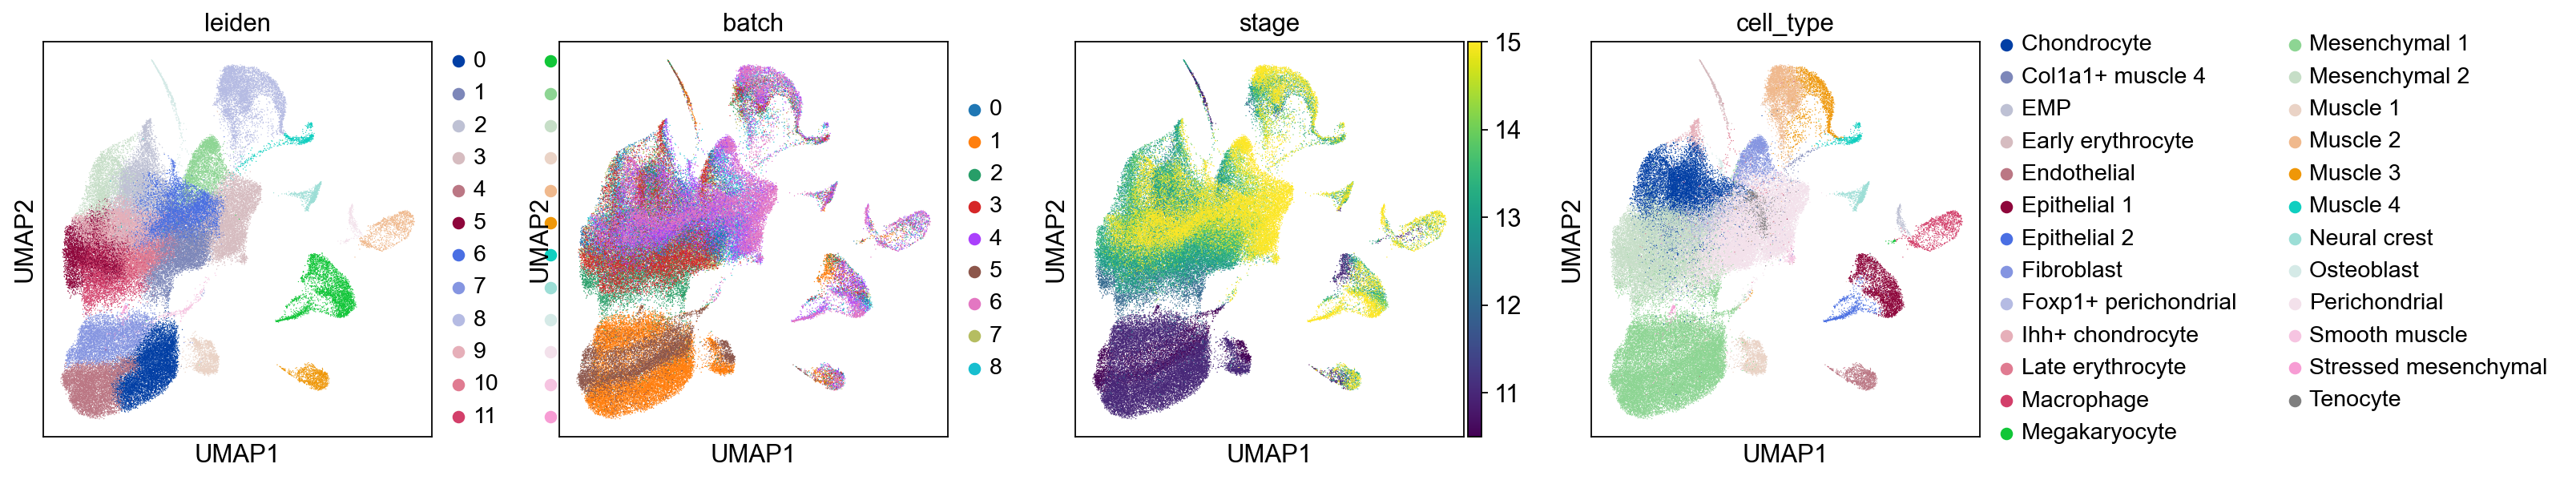

In [29]:
plts = ['leiden', 'batch','stage','cell_type']

sc.pl.umap(adata, color = plts) # can save the plot by adding arg `save = 'filename.png/pdf/svg'

### Pathway States <a class="anchor" id="9-bullet"></a>

We might be interested in expression of Notch components across cell types and clusters, but when comparing expression values, it's recommended to use normalized values. 

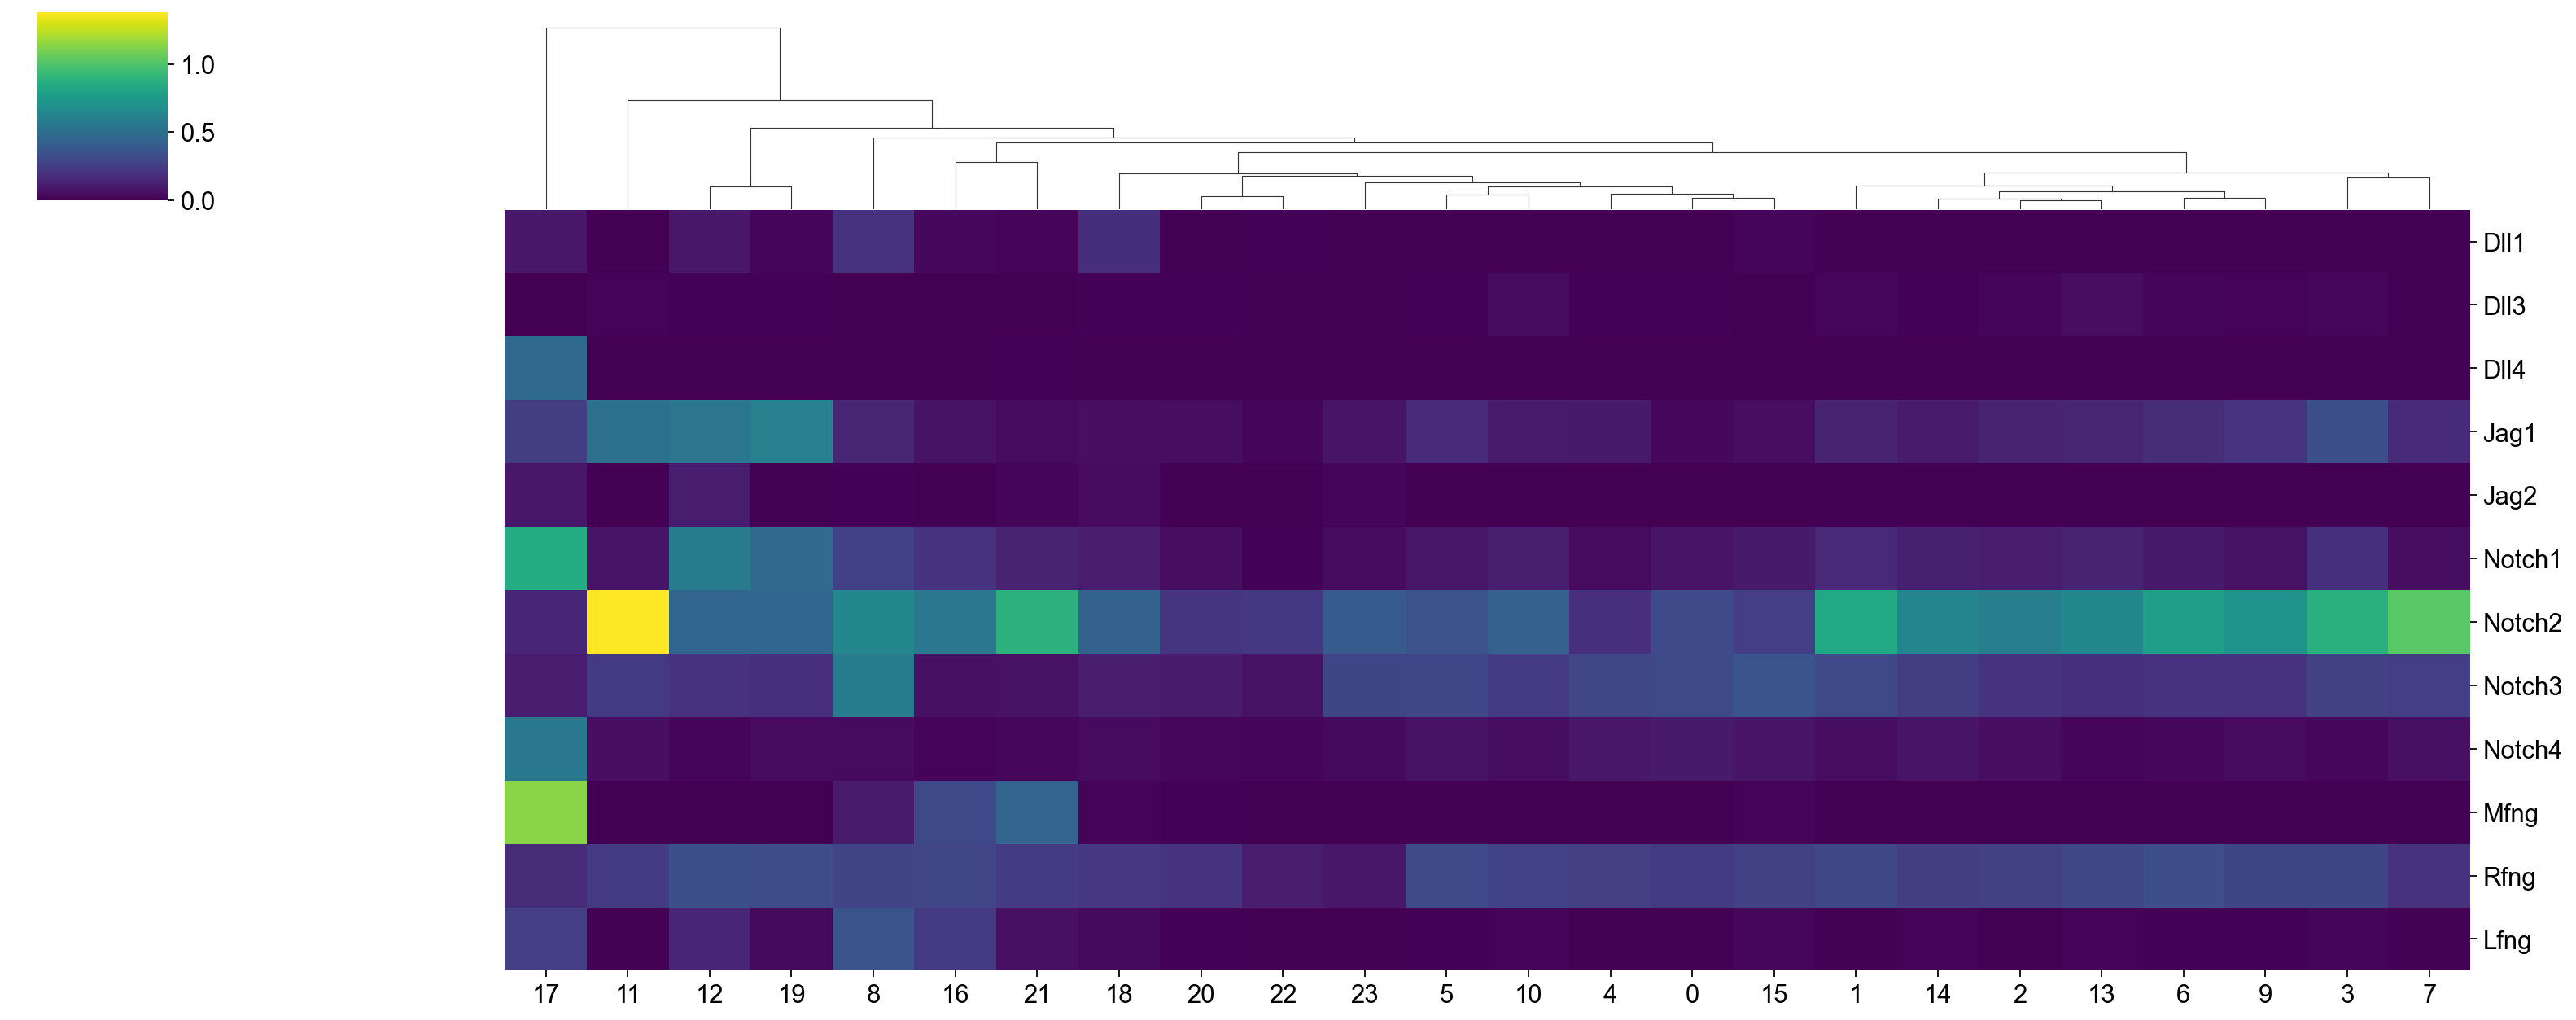

In [30]:
# Function to get a heatmap of normalized gene values
df = sc_sp.gene_expression_norm(adata, notch, partition_key="leiden")

g = sb.clustermap(df, cmap='viridis', row_cluster=False, figsize=(20,8))

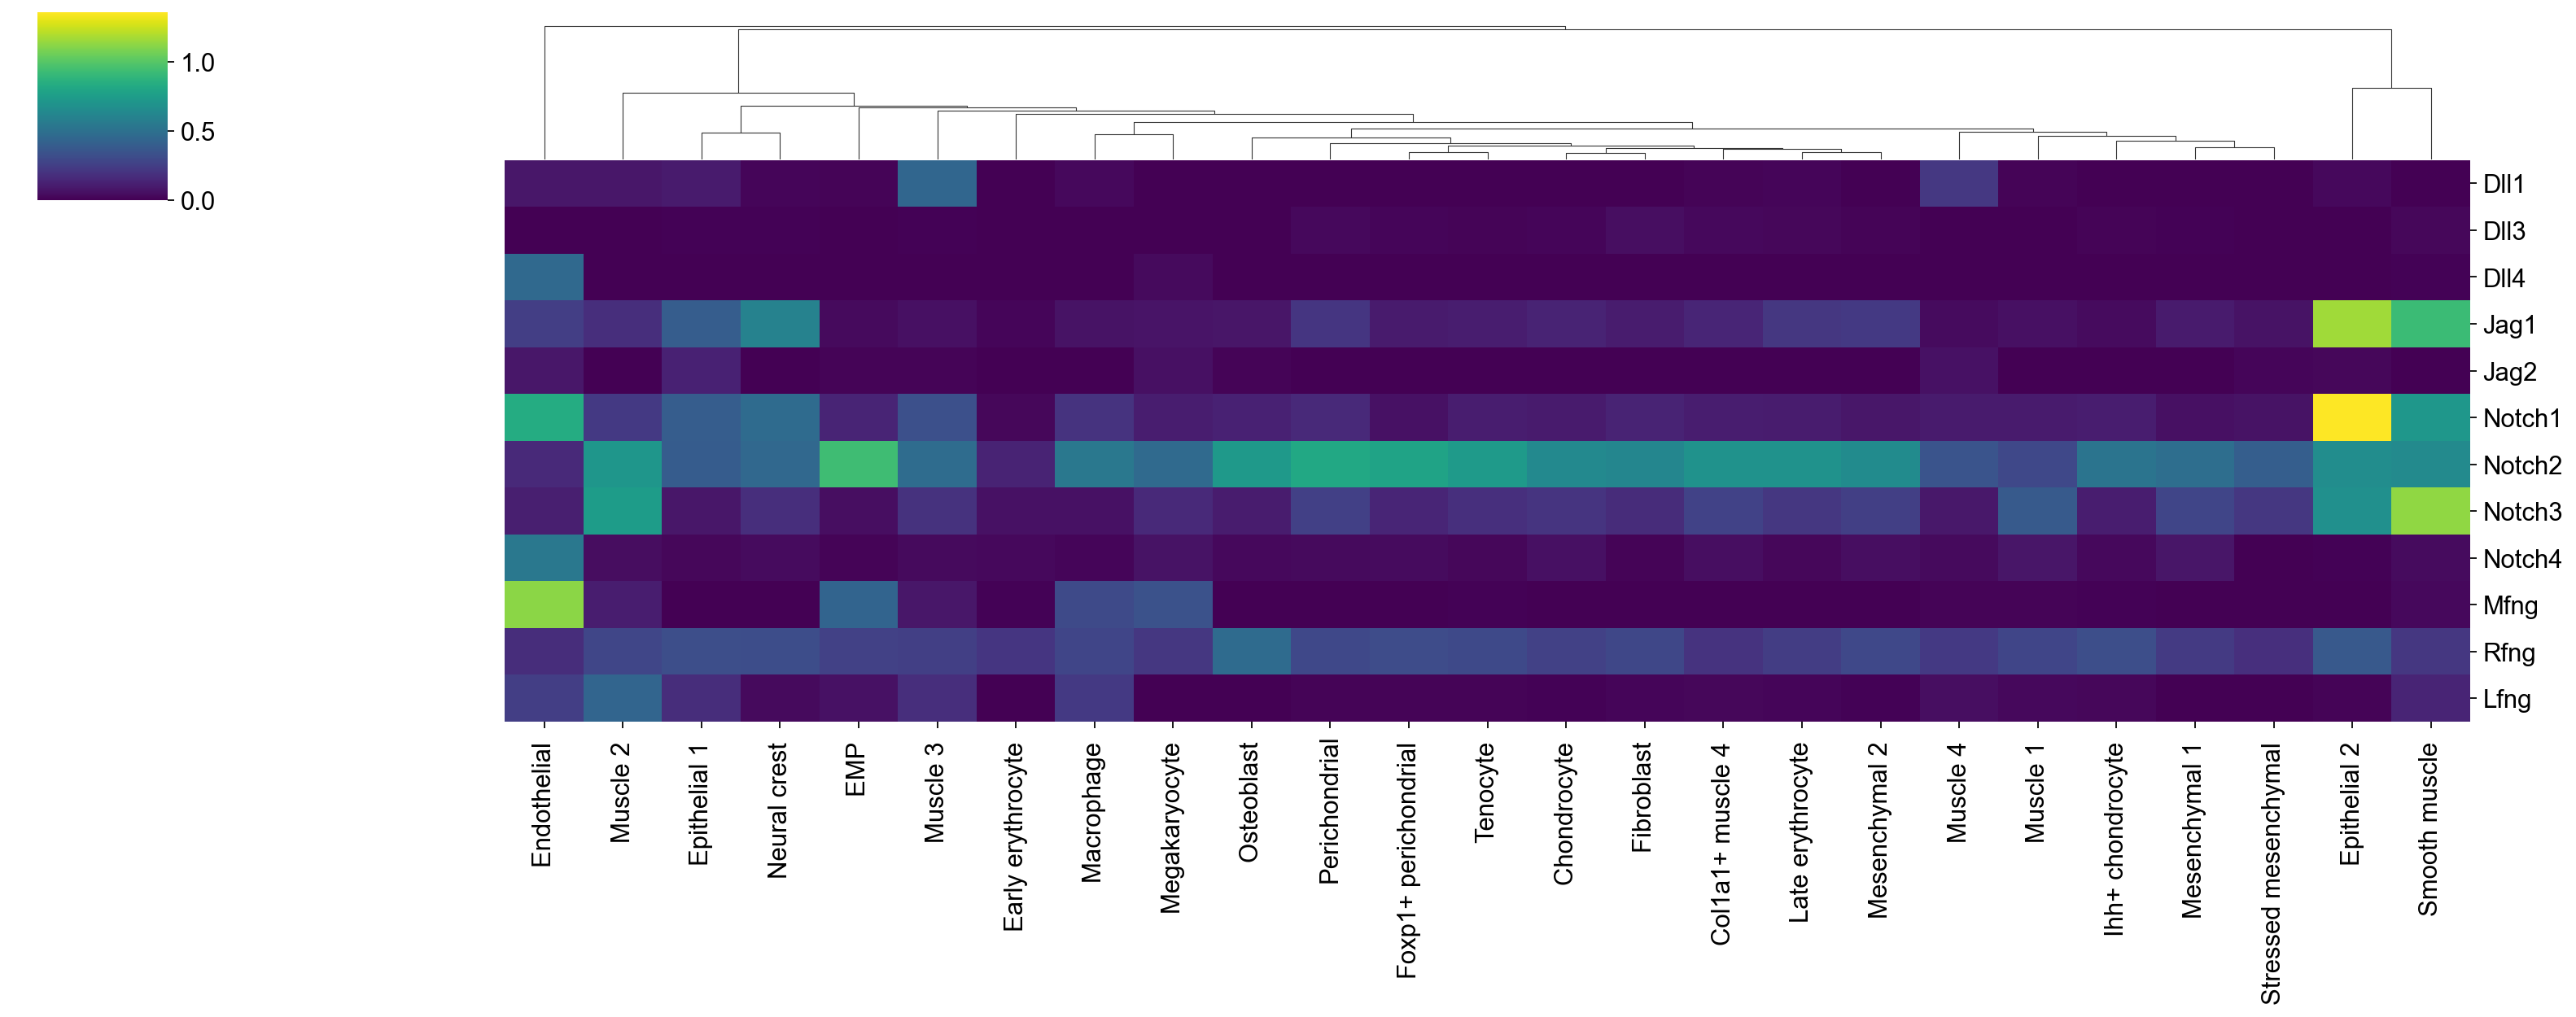

In [31]:
# Function to get a heatmap of normalized gene values
df = sc_sp.gene_expression_norm(adata, notch, partition_key="cell_type")

g = sb.clustermap(df, cmap='viridis', row_cluster=False, figsize=(20,8))

## Conclusion <a class="anchor" id="15-bullet"></a>

AnnData objects use the [hdf5 file format](https://www.hdfgroup.org/solutions/hdf5/) to save all count data and annotations.

In [32]:
# Save the whole forelimb AnnData objects
del adata.obs[False] # weird obs attribute that gets tacked on, cannot save w/o this step
adata.write_h5ad(resdir + "forelimb_adata.h5ad")

In [33]:
%load_ext watermark
%watermark -v -p numpy,pandas,scipy,seaborn,matplotlib,anndata,scanpy,jupyterlab

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

numpy     : 1.20.3
pandas    : 1.3.4
scipy     : 1.5.3
seaborn   : 0.11.2
matplotlib: 3.5.0
anndata   : 0.7.8
scanpy    : 1.8.2
jupyterlab: 3.2.5

